In [1]:
import os
from typing import List, Tuple
import time

from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchinfo import summary

from torch_code.helper_functions import plot_loss_curves
from torch_code import engine

/home/enzo/anaconda3/envs/ViT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
def pred_tensor(
                model: torch.nn.Module,
                class_names: List[str],
                image_tensor: torch.Tensor,
                image_transform: torchvision.transforms,
                device: torch.device,
               ):
    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(image_tensor).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_idx = torch.argmax(target_image_pred_probs, dim=1)
    
    return class_names[target_image_pred_idx], target_image_pred_idx, target_image_pred_probs.max()

def pred_pil(
                model: torch.nn.Module,
                class_names: List[str],
                image_pil: Image,
                image_transform: torchvision.transforms,
                device: torch.device,
               ):
    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(image_pil).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_idx = torch.argmax(target_image_pred_probs, dim=1)
    
    return class_names[target_image_pred_idx], target_image_pred_idx, target_image_pred_probs.max()
    
    

def pred_and_plot_image(
                        model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_transform: torchvision.transforms,
                        device: torch.device,
                        ):
    """Predicts on a target image with a target model after applying a target transformation.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img_torch = read_image(image_path)
    img = Image.open(image_path)

    ### Predict on image ###
    if 'ImageClassification' in str(type(image_transform)):
        pred_label_name, pred_label_idx, pred_prob = pred_tensor(model, 
                                                             class_names, 
                                                             img_torch, 
                                                             image_transform, 
                                                             device)
    else:    
        pred_label_name, pred_label_idx, pred_prob = pred_pil(model, 
                                                             class_names, 
                                                             img, 
                                                             image_transform, 
                                                             device)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {pred_label_name} | Prob: {pred_prob:.3f}"
    )
    plt.axis(False)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Setup directory paths to train and test images
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Create Datasets and DataLoaders

In [5]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
                        train_dir: str, 
                        test_dir: str, 
                        transform: transforms.Compose, 
                        batch_size: int, 
                        num_workers: int=NUM_WORKERS
                        ):

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
str(manual_transforms.transforms[1])

'ToTensor()'

In [8]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa444463760>,
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

torch.Size([3, 224, 224]) tensor(2)


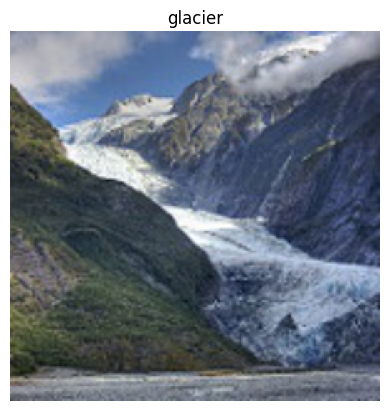

In [9]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# Step 1 

#### Tasks:

1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (196, 768) -> N×(P2⋅C)       #Current shape: (1, 768, 196)

In [10]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

# PatchEmbedding layer

In [11]:
# Let's test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [12]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6947,  0.1862, -0.2346,  ...,  0.5306, -0.2867,  0.2463],
         [-0.7528,  0.1857, -0.2176,  ...,  0.5620, -0.2794,  0.2532],
         [-0.6905,  0.2123, -0.2134,  ...,  0.5244, -0.3082,  0.2532],
         ...,
         [-0.4504,  0.1707, -0.1520,  ...,  0.3529, -0.2734,  0.1838],
         [-0.4327,  0.1852, -0.1296,  ...,  0.4054, -0.2820,  0.0695],
         [-0.4679,  0.1583, -0.1217,  ...,  0.4009, -0.2885,  0.1110]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [13]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6947,  0.1862, -0.2346,  ...,  0.5306, -0.2867,  0.2463],
         [-0.7528,  0.1857, -0.2176,  ...,  0.5620, -0.2794,  0.2532],
         ...,
         [-0.4504,  0.1707, -0.1520,  ...,  0.3529, -0.2734,  0.1838],
         [-0.4327,  0.1852, -0.1296,  ...,  0.4054, -0.2820,  0.0695],
         [-0.4679,  0.1583, -0.1217,  ...,  0.4009, -0.2885,  0.1110]]],
       grad_fn=<CatBackward0>)


Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

# Lets create layers used in Transformer's encoder:


#### Norm (LN or LayerNorm) - torch.nn.LayerNorm().

Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).


#### We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

Multi-Head Self Attention (MSA) - <b>torch.nn.MultiheadAttention()</b>

    embed_dim - the embedding dimension D .

    num_heads - how many attention heads to use (this is where the term "multihead" comes from)

    dropout - whether or not to apply dropout to the attention layer 

    batch_first - does our batch dimension come first? (yes it does)

In [14]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# MLP Block

In [15]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Creating a Transformer Encoder by combining our custom made layers

In below cell we are creating transformer encoder ourself

In [16]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x
    


#### Transformer Encoder block created!

In [17]:
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Building the Vision Transformer

In [18]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

# Train Model

In [19]:
# Train our MOdel

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))


In [20]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=2,
                       device=device)

 50%|██████████████████████                      | 1/2 [06:11<06:11, 371.84s/it]

Epoch: 1 | train_loss: 1.8828 | train_acc: 0.1690 | test_loss: 1.7921 | test_acc: 0.1692


100%|████████████████████████████████████████████| 2/2 [12:27<00:00, 373.70s/it]

Epoch: 2 | train_loss: 1.7918 | train_acc: 0.1695 | test_loss: 1.7905 | test_acc: 0.1745


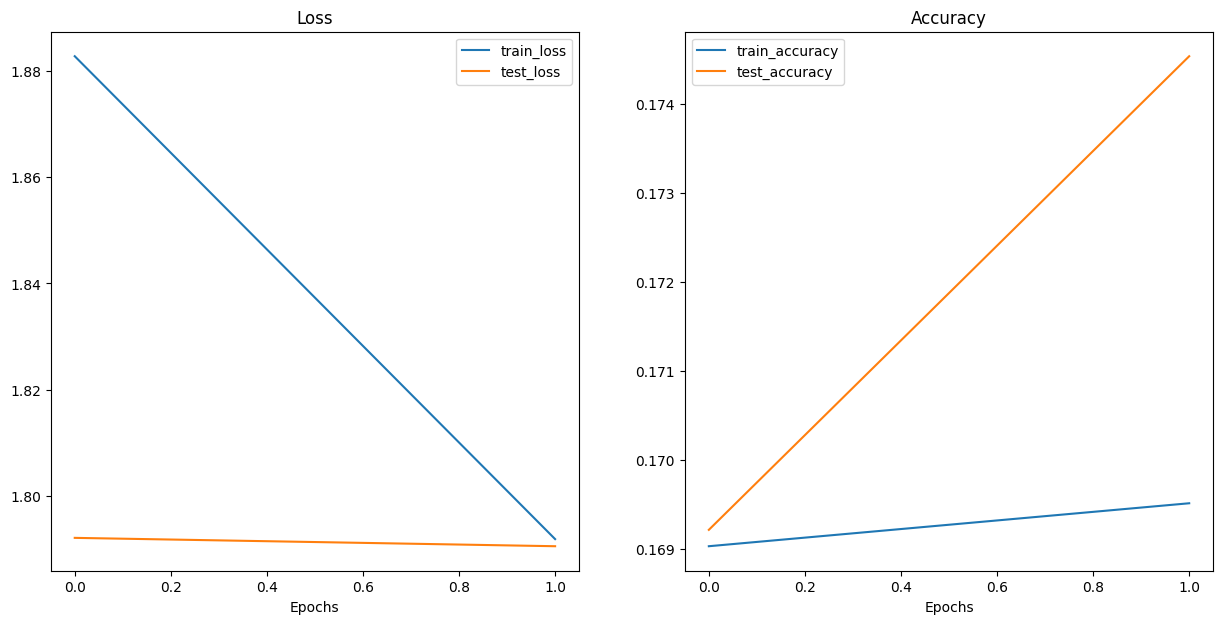

In [21]:
# Plot our ViT model's loss curves
plot_loss_curves(results)

# Predictions

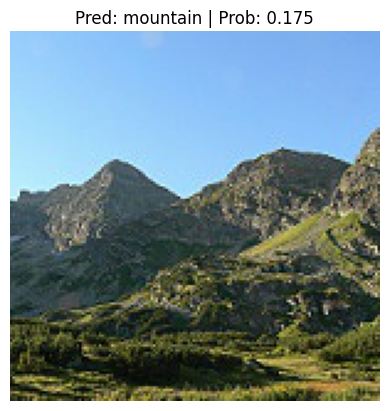

In [37]:
# Setup custom image path
custom_image_path = "test_image.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_transform=manual_transforms,
                    device=device
                   )

# Image classifier using pretrained model

In [23]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [24]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [25]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [26]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [27]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device)

  5%|██▏                                        | 1/20 [02:08<40:50, 128.97s/it]

Epoch: 1 | train_loss: 0.2778 | train_acc: 0.9083 | test_loss: 0.2116 | test_acc: 0.9212


 10%|████▎                                      | 2/20 [04:18<38:42, 129.01s/it]

Epoch: 2 | train_loss: 0.1874 | train_acc: 0.9341 | test_loss: 0.2027 | test_acc: 0.9283


 15%|██████▍                                    | 3/20 [06:30<36:58, 130.50s/it]

Epoch: 3 | train_loss: 0.1685 | train_acc: 0.9408 | test_loss: 0.1932 | test_acc: 0.9283


 20%|████████▌                                  | 4/20 [08:41<34:51, 130.69s/it]

Epoch: 4 | train_loss: 0.1593 | train_acc: 0.9437 | test_loss: 0.1839 | test_acc: 0.9340


 25%|██████████▊                                | 5/20 [10:52<32:41, 130.78s/it]

Epoch: 5 | train_loss: 0.1483 | train_acc: 0.9469 | test_loss: 0.1789 | test_acc: 0.9336


 30%|████████████▉                              | 6/20 [12:56<29:58, 128.45s/it]

Epoch: 6 | train_loss: 0.1423 | train_acc: 0.9493 | test_loss: 0.1784 | test_acc: 0.9326


 35%|███████████████                            | 7/20 [14:59<27:30, 126.93s/it]

Epoch: 7 | train_loss: 0.1364 | train_acc: 0.9498 | test_loss: 0.1845 | test_acc: 0.9323


 40%|█████████████████▏                         | 8/20 [17:04<25:14, 126.23s/it]

Epoch: 8 | train_loss: 0.1313 | train_acc: 0.9522 | test_loss: 0.1795 | test_acc: 0.9320


 45%|███████████████████▎                       | 9/20 [19:08<22:59, 125.43s/it]

Epoch: 9 | train_loss: 0.1284 | train_acc: 0.9523 | test_loss: 0.1801 | test_acc: 0.9343


 50%|█████████████████████                     | 10/20 [21:13<20:52, 125.24s/it]

Epoch: 10 | train_loss: 0.1240 | train_acc: 0.9557 | test_loss: 0.1751 | test_acc: 0.9366


 55%|███████████████████████                   | 11/20 [23:16<18:42, 124.75s/it]

Epoch: 11 | train_loss: 0.1214 | train_acc: 0.9551 | test_loss: 0.1846 | test_acc: 0.9326


 60%|█████████████████████████▏                | 12/20 [25:20<16:35, 124.46s/it]

Epoch: 12 | train_loss: 0.1193 | train_acc: 0.9570 | test_loss: 0.1860 | test_acc: 0.9320


 65%|███████████████████████████▎              | 13/20 [27:24<14:29, 124.26s/it]

Epoch: 13 | train_loss: 0.1172 | train_acc: 0.9576 | test_loss: 0.1791 | test_acc: 0.9356


 70%|█████████████████████████████▍            | 14/20 [29:28<12:24, 124.12s/it]

Epoch: 14 | train_loss: 0.1138 | train_acc: 0.9574 | test_loss: 0.1843 | test_acc: 0.9333


 75%|███████████████████████████████▌          | 15/20 [31:31<10:20, 124.00s/it]

Epoch: 15 | train_loss: 0.1106 | train_acc: 0.9595 | test_loss: 0.1871 | test_acc: 0.9337


 80%|█████████████████████████████████▌        | 16/20 [33:35<08:15, 123.84s/it]

Epoch: 16 | train_loss: 0.1094 | train_acc: 0.9607 | test_loss: 0.1948 | test_acc: 0.9280


 85%|███████████████████████████████████▋      | 17/20 [35:39<06:11, 123.80s/it]

Epoch: 17 | train_loss: 0.1078 | train_acc: 0.9597 | test_loss: 0.1885 | test_acc: 0.9303


 90%|█████████████████████████████████████▊    | 18/20 [37:42<04:07, 123.77s/it]

Epoch: 18 | train_loss: 0.1056 | train_acc: 0.9599 | test_loss: 0.1894 | test_acc: 0.9323


 95%|███████████████████████████████████████▉  | 19/20 [39:46<02:03, 123.75s/it]

Epoch: 19 | train_loss: 0.1037 | train_acc: 0.9620 | test_loss: 0.1944 | test_acc: 0.9291


100%|██████████████████████████████████████████| 20/20 [41:50<00:00, 125.50s/it]

Epoch: 20 | train_loss: 0.1029 | train_acc: 0.9626 | test_loss: 0.1944 | test_acc: 0.9311


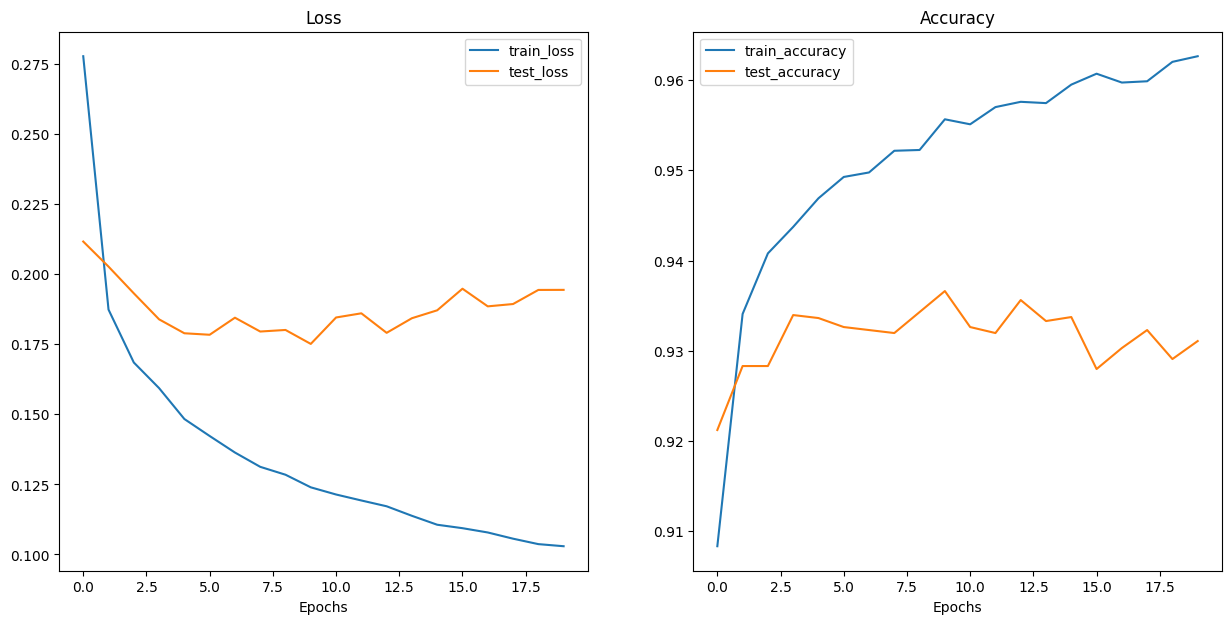

In [28]:
plot_loss_curves(pretrained_vit_results)

## Run trained model on image

/home/enzo/anaconda3/envs/ViT/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


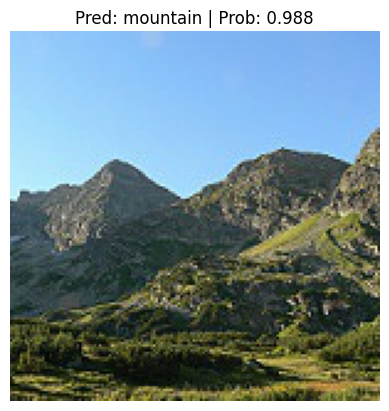

In [36]:
# Setup custom image path
custom_image_path = "test_image.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names, 
                    image_transform=pretrained_vit_transforms,
                   device=device)

## Save model

In [38]:
save_model_path = "trained_vit.pth"
torch.save(pretrained_vit, save_model_path)

## Load model

In [39]:
trained_vit = torch.load(save_model_path)

## Run saved model on image

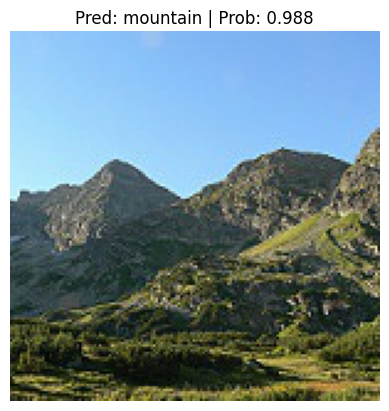

In [42]:
# Predict on custom image
pred_and_plot_image(model=trained_vit,
                    image_path=custom_image_path,
                    class_names=class_names, 
                    image_transform=pretrained_vit_transforms,
                    device=device)

## Benchmark model

In [43]:
times = []
benchmark_tensor = read_image(custom_image_path)
for i in range(100):
    start = time.time()
    pred_label_name, pred_label_idx, pred_prob = pred_tensor(trained_vit, 
                                                             class_names, 
                                                             benchmark_tensor, 
                                                             pretrained_vit_transforms, 
                                                             device)
    times.append(time.time() - start)
avg_pred_time = sum(times)/len(times)
print(f"ViT prediction FPS:{(1/avg_pred_time): .1f}")

ViT prediction FPS: 78.3
